# <유동인구분석(SKT)>

In [354]:
# !pip install networkx[default]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
from datetime import datetime,timedelta
import time
import networkx

pd.set_option('display.max_rows',300)

from matplotlib import font_manager, rc
#matplotlib.rcParams['font.family']='Malgun Gothic'
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import seaborn as sns
sns.set(rc = {'figure.figsize':(10,6)})
plt.rc('font', family=font_name)

## 전처리

In [2]:
 # 1,2,3월 데이터 병합
data = pd.read_csv('../data/데이터_SK텔레콤/전북_군산/군산_202101.csv',sep='|')
for i in range(2,4):
    data = pd.concat([data,pd.read_csv(f'../data/데이터_SK텔레콤/전북_군산/군산_20210{i}.csv',sep='|')]\
                     ,ignore_index=True)

 # 결측치 제거
print(data.shape , data.dropna().shape)
data = data.dropna()

 #  날짜를 datetime타입으로 변경
data.STD_YMD = pd.to_datetime(data.STD_YMD, format='%Y%m%d')

# 사용하지 않을 열 삭제
data = data.drop('STD_YM',axis=1)
data = data.drop('dst_DO_NAME',axis=1)

# 가독성을 위한 열이름 변경
data.columns = ['date','day','home_code','home_do','home_gu','dst_gu','dst_dong','dst_code','age','sex','pops','type']
# pop is method!

# 가독성을 위한 라벨명 변경
data.sex.replace(1,'남',inplace=True)
data.sex.replace(2,'여',inplace=True)

# 구코드를 도+구로 변경하여 다른 지방자치단체의 같은 구명칭 문제해결 ( 32개의 겹치는 구이름이 있음)
data.home_gu=data.home_do+' '+data.home_gu

(1212221, 14) (1212221, 14)


In [3]:
data.head()

,date,day,home_code,home_do,home_gu,dst_gu,dst_dong,dst_code,age,sex,pops,type
0,2021-01-25,월,11110,서울특별시,서울특별시 종로구,군산시,옥구읍,4513025000,30G,남,1.680952,NO
1,2021-01-26,화,11110,서울특별시,서울특별시 종로구,군산시,옥구읍,4513025000,30G,남,1.680952,NO
2,2021-01-27,수,11110,서울특별시,서울특별시 종로구,군산시,옥구읍,4513025000,30G,남,1.680952,NO
3,2021-01-28,목,11110,서울특별시,서울특별시 종로구,군산시,옥구읍,4513025000,60G,남,1.658537,NO
4,2021-01-30,토,11110,서울특별시,서울특별시 종로구,군산시,옥구읍,4513025000,50G,여,1.262987,NO


## Functions

In [4]:
# 플롯을 용이하게 하기위한 함수들 정의
def ploteda(i,w=8,h=4):
    x=data.columns[i]
    return data[x].value_counts().sort_index().plot(title=x,figsize=(w,h))

def ploteda_v(i,w=8,h=4):
    x=data.columns[i]
    return data[x].value_counts().sort_values(ascending=False).plot(kind='bar',title=x,figsize=(w,h))
 
# 유동인구로 가중치 적용한 데이터
def wdf(i):
    return data.pivot_table(index=data.columns[i],values='pops',aggfunc='sum').rename_axis(index=None)

def wploteda(i,w=8,h=4):
    return wdf(i).sort_index().plot(title=data.columns[i],figsize=(w,h))

def wploteda_v(i,topn=len(wdf(i)),w=8,h=4):
    x=data.columns[i]
    return wdf(i).iloc[:,0].sort_values(ascending=False)[:topn].plot(kind='bar',title=data.columns[i],figsize=(w,h))
                   # make it Series to sort
    
# 유동인구로 가중치 적용한 데이터 군산to군산
def wdf_gs(i):
    return data_gs.pivot_table(index=data_gs.columns[i],values='pops',aggfunc='sum').rename_axis(index=None)

def wploteda_gs(i,w=8,h=4):
    return wdf_gs(i).sort_index().plot(title=data_gs.columns[i],figsize=(w,h))

def wploteda_v_gs(i,t=0,w=8,h=4):
    if t==0:
        topn=len(wdf_gs(i))
    else:
        topn=t
    return wdf_gs(i).iloc[:,0].sort_values(ascending=False)[:topn].plot(kind='bar',title=data_gs.columns[i],figsize=(w,h))
                   # make it Series to sort
    


## 데이터 분포 탐색 (유동인구로 가중치주지 않고 단순 분포탐색)

### 플롯들이 균일하지 않은것으로 유동인구=0인 rows 삭제된 것으로 추정가능

<AxesSubplot:title={'center':'date'}>

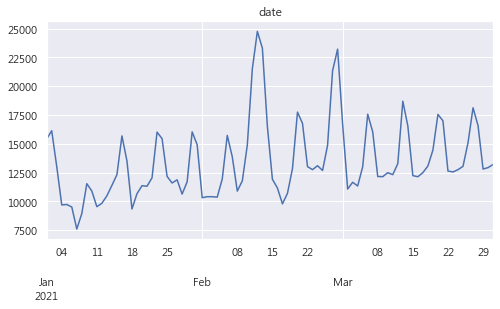

In [5]:
ploteda(0)

In [6]:
#ploteda(1)

In [7]:
#ploteda_v(3,11,4)

In [8]:
#ploteda(4,14,4)

In [9]:
#ploteda_v(6)

In [10]:
#ploteda_v(8)

In [11]:
#ploteda_v(9)

In [12]:
#ploteda_v(11)

In [13]:
# 관광으로 라벨링이 잘 안되어 있음을 확인 
#data[data.iloc[:,11]=='TOUR']

## 표준편차(이상치) 탐색

### 유동인구 column 분포확인

In [14]:
data.pops.describe()

count    1.212221e+06
mean     4.134359e+01
std      3.396500e+02
min      1.000000e+00
25%      1.927083e+00
50%      2.941788e+00
75%      5.724986e+00
max      1.222714e+04
Name: pops, dtype: float64

In [15]:
summ = data.pops.sum()
mean = data.pops.mean()
med = data.pops.median()
std = data.pops.std() 
print('sum:', round(summ,2),'  ','mean:', round(mean,2),'  ','med:',round(med,2),'  ','std:', round(std,2))
print(round(mean+std,2),'명 이상인 유동인구가 상위 1표준편차에 해당합니다.')
print('\n')

def data_pops_sig(x):
    print(mean+x*std)
    return data[data.pops >= mean+x*std_fq]
def data_pops_except_sig(x):
    print(mean+x*std)
    return data[data.pops < mean+x*std_fq]

sum: 50117566.64    mean: 41.34    med: 2.94    std: 339.65
380.99 명 이상인 유동인구가 상위 1표준편차에 해당합니다.




## 유동인구 가중 EDA

In [16]:
#print(data.pops.sum(),data.pivot_table(index='sex',values='pops',aggfunc='sum').sum()[0]) # for check
#data.pivot_table(index='sex',values='pops',aggfunc='sum')

### 도별 군산유입인구

<AxesSubplot:title={'center':'home_do'}>

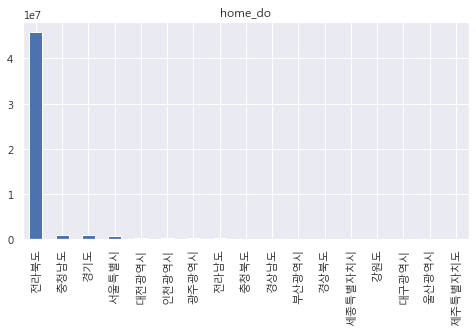

In [17]:
wploteda_v(3)

### 시/구별 군산유입인구 (군산내부유동인구가 압도적으로 많은 것을 확인 => 군산내부유동/외부유입을 구분할 필요성)

<AxesSubplot:title={'center':'home_gu'}>

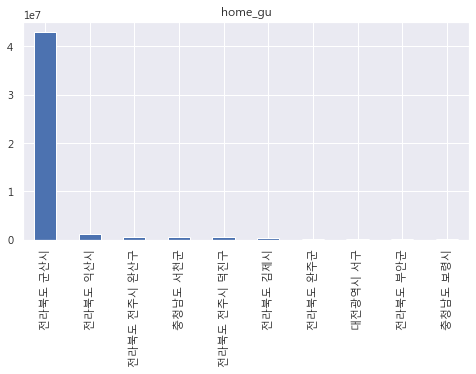

In [18]:
wploteda_v(4,10)

## 군산외부 to군산 유입인구

### 군산내부유동/외부유입 분리

In [19]:
data_gs = data[data.home_gu == '전라북도 군산시']
data = data[data.home_gu != '전라북도 군산시']

### 일자별 외부유입인구

<AxesSubplot:title={'center':'date'}>

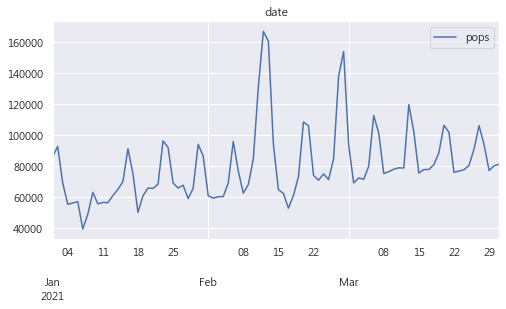

In [20]:
wploteda(0)

### 요일별 유입인구  주말이 높지만 압도적이지는 않음

<AxesSubplot:title={'center':'day'}>

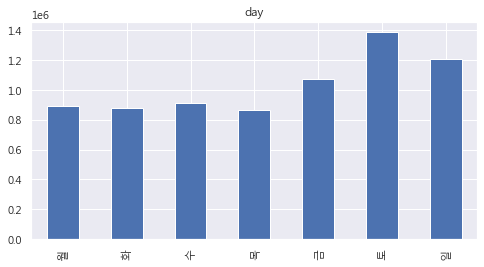

In [21]:
# wploteda(1)

day = wdf(1)
day['orderday']=[5,4,3,1,7,6,2]
day.sort_values(by='orderday').pops.plot(kind='bar',title='day',figsize=(8,4))

### 유입지별 유입인구

<AxesSubplot:title={'center':'home_do'}>

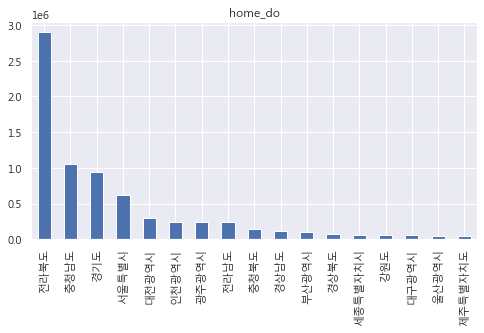

In [22]:
wploteda_v(3)

전라북도 익산시        30619
전라북도 전주시 완산구    27642
충청남도 서천군        24563
Name: home_gu, dtype: int64

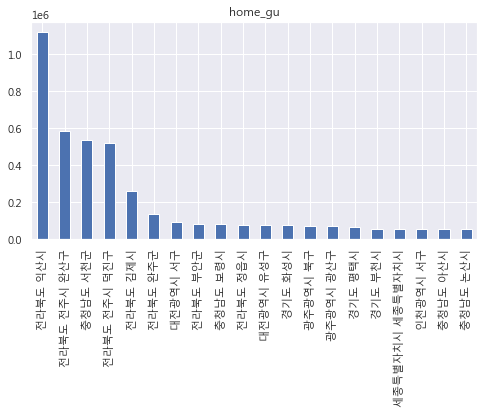

In [23]:
#wploteda_v(2,10)
wploteda_v(4,20)
topgu = list(wdf(2).iloc[:,0].sort_values()[-3:].index)
data.query(f'home_code in {topgu}').home_gu.value_counts()

### 유입지별 유입인구 (networkx)

In [24]:
docomer = pd.concat([wdf(3),pd.DataFrame({'pops':0},index=['군산'])])

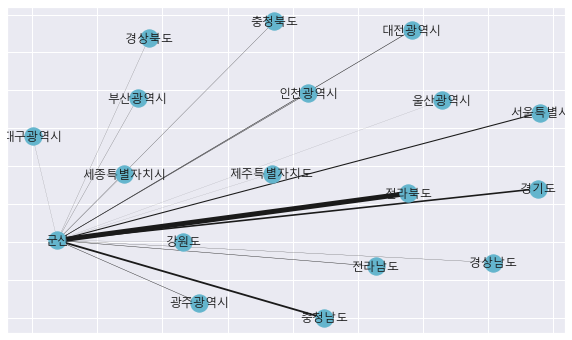

In [25]:
import networkx as nx
nodes = list(docomer.index)
graph = networkx.Graph()
graph.add_nodes_from(nodes)
mat=np.matrix

a=np.matrix(np.zeros([len(docomer)-1,len(docomer)]))
b=docomer.values
mat=np.matrix(np.vstack([a,b.T]))
#from scipy.sparse import random
#mat = random(len(docomer),len(docomer),density=0.3).todense()

for r, rval in enumerate(nodes):
    for c, cval in enumerate(nodes):
        if c<r:
            graph.add_edge(rval,cval, weight1231=mat[r,c])

pos = nx.spring_layout(graph)
edges = graph.edges()

weights = [abs(graph[u][v]['weight1231']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

plt.figure()
nx.draw_networkx_nodes(graph, pos=pos, nodelist=nodes, node_color='c')
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos, font_family='Malgun Gothic')
plt.show()

### 목적 (행정)동별 군산 유입인구  (거주지와 산업단지 > 관광지)

<AxesSubplot:title={'center':'dst_dong'}>

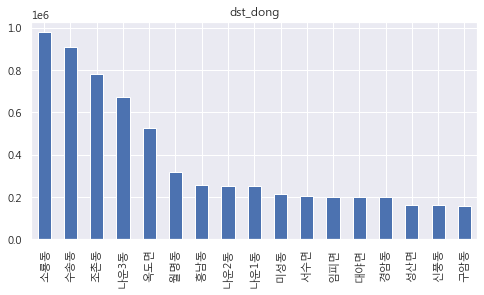

In [26]:
wploteda_v(6)
# wploteda_v(7)

### 목적지 성격별 유입인구

<AxesSubplot:title={'center':'type'}>

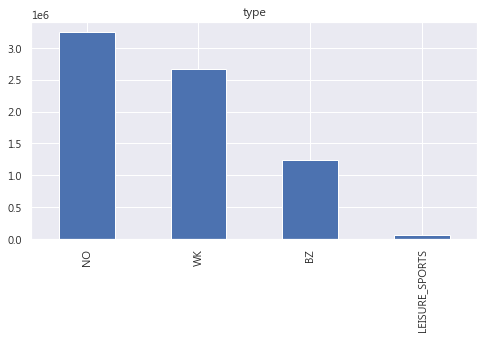

In [27]:
wploteda_v(11)

### 군산시 상세인구분포 (연령&성별)

<AxesSubplot:>

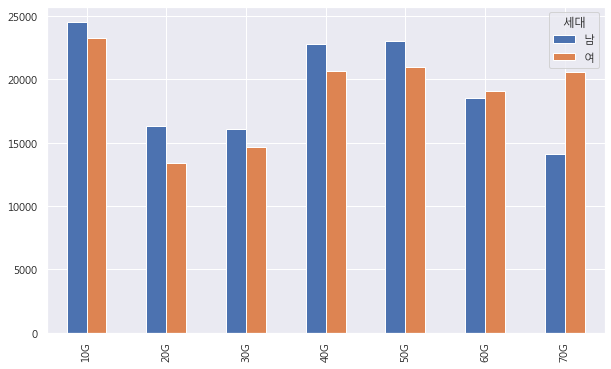

In [29]:
pop_gs = pd.read_excel('../data/군산시상세인구20210706(KOSIS)_간추림.xlsx',header=None)
pop_gs = pop_gs.set_index(0).rename_axis(index=None)
# pop_gs.columns=['군산']
# pop_gs.plot(title='군산시 연령별 인구',legend=False,figsize=(8,4))

pop_gs.columns=pop_gs.iloc[0]
pop_gs =  pop_gs.drop('세대',axis=0).drop('전체',axis=1)
pop_gs.plot(kind='bar')#, color=['b','r'])

### 연령별 군산 유입인구와 전국인구와의 비교

<AxesSubplot:title={'center':'연령별 군산유입인구와 전국인구분포(%)'}>

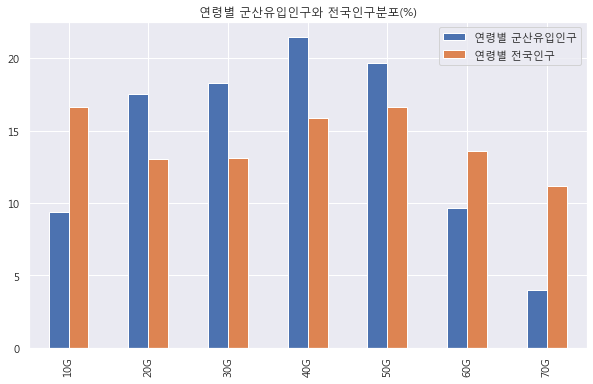

In [30]:
pop_gs_comer = wdf(8)
pop_gs_comer = (100*pop_gs_comer)/(pop_gs_comer.iloc[:,0].sum())
pop_gs_comer.columns = ['연령별 군산유입인구']
pop_kor = pd.read_excel('../data/2021전국인구(행안부주민등록인구통계).xlsx').T
pop_kor = (100*pop_kor)/(pop_kor.iloc[:,0].sum())
pop_kor.columns=['연령별 전국인구']

pd.concat([pop_gs_comer,pop_kor],axis=1).plot(kind='bar',title='연령별 군산유입인구와 전국인구분포(%)')

### 성별&연령별 군산 유입인구

<AxesSubplot:title={'center':'성별/연령별 군산시 방문객수'}, xlabel='age'>

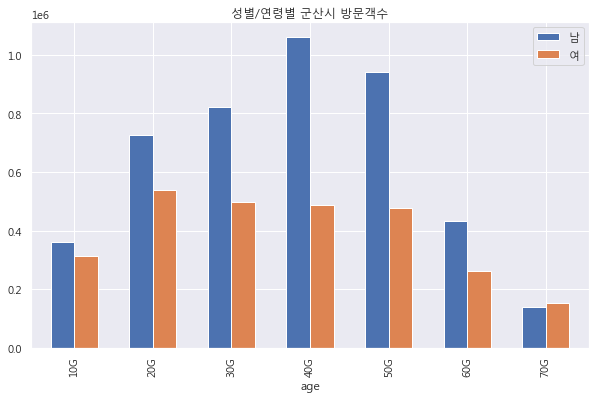

In [31]:
data.pivot_table(index = 'sex', columns='age', values='pops',aggfunc='sum')\
.rename_axis(index=None).T.plot(kind='bar',figsize=(10,6),width=0.6,title='성별/연령별 군산시 방문객수')

# 목적지별(행정동) 상세분석

In [32]:
dong_list=list(data.dst_dong.value_counts().index)

In [33]:
#for i,dong in enumerate(dong_list):
#    exec("data_%s=data[data.dst_dong=='%s']" % (dong,dong))

### 군산을 제외한 전국에서의 유입 목적지

<AxesSubplot:>

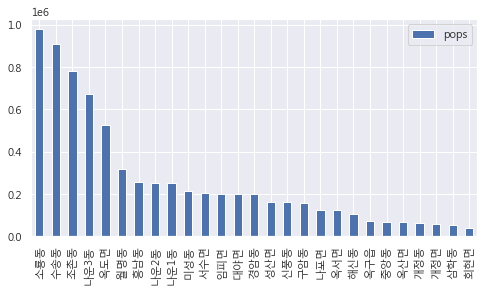

In [34]:
data.pivot_table(index='dst_dong',values='pops',aggfunc='sum').rename_axis(index=None).sort_values('pops',ascending=False)\
.plot(kind='bar',figsize=(8,4))

### 서울에서의 유입 목적지

<AxesSubplot:>

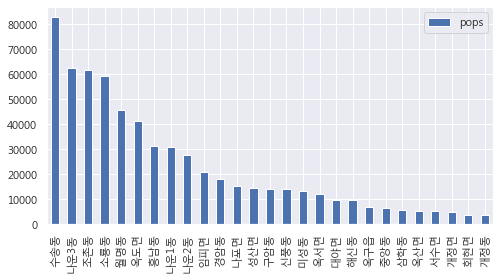

In [35]:
data[data.home_do=='서울특별시'].pivot_table(index='dst_dong',values='pops',aggfunc='sum').rename_axis(index=None).sort_values('pops',ascending=False)\
.plot(kind='bar',figsize=(8,4))

### feature별 동유입수와 비율

In [36]:
def wdong(feature):
    return data.pivot_table(index='dst_dong', columns=feature, values='pops',aggfunc='sum').rename_axis(index=None)
def wdong_ratio(feature):
    wdongr=wdong(feature)
    wdongr.insert(0,"tot",wdongr.sum(1),True)
    return wdongr.iloc[:,1:].div(wdongr.tot,axis=0)

def wdong_plot(feature):
    wdong(feature).T.plot(figsize=(12,8))
def wdong_ratio_plot(feature):
    wdong_ratio(feature).T.plot(figsize=(12,8))

In [37]:
interested_dong = ['옥도면','월명동','경암동','중앙동','해신동','나운3동','수송동','조촌동','소룡동'] 
tour_dong = ['옥도면','월명동','경암동'] #'중앙동','해신동',나운3동

### 연령별 동유입수

<AxesSubplot:xlabel='age'>

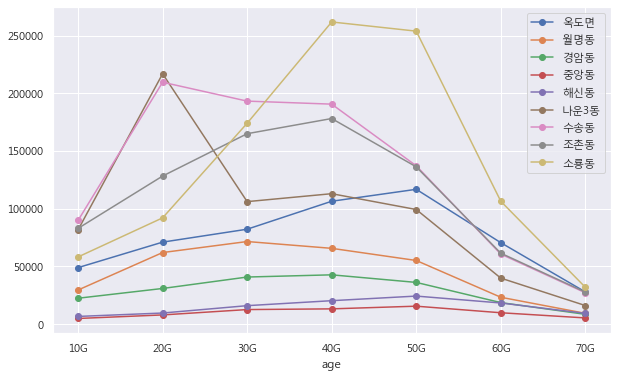

In [38]:
wdong('age').loc[interested_dong].T.plot(figsize=(10,6),marker='o')

### 주말 연령별, 성별 주요 관광지 유입인구★

<AxesSubplot:xlabel='age'>

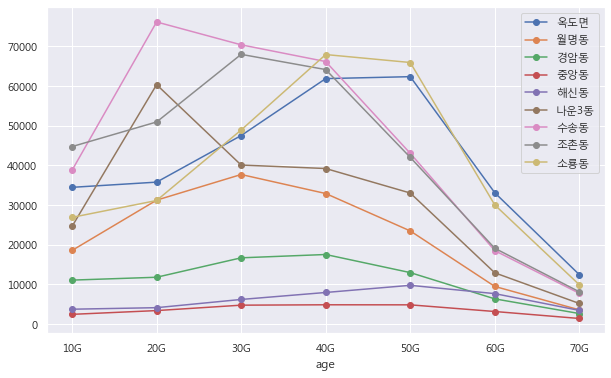

In [39]:
data[data.day.isin(['토','일'])].pivot_table(index='dst_dong', columns='age', values='pops',aggfunc='sum').rename_axis(index=None).loc[interested_dong].T.plot(figsize=(10,6),marker='o')

<AxesSubplot:xlabel='age,sex'>

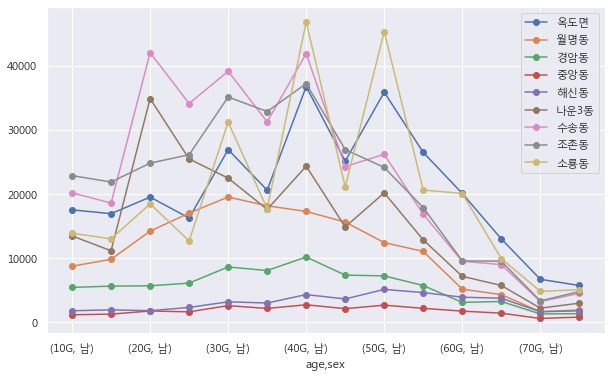

In [40]:
data[data.day.isin(['토','일'])].pivot_table(index='dst_dong', columns=['age','sex'], values='pops',aggfunc='sum').rename_axis(index=None).loc[interested_dong].T.plot(figsize=(10,6),marker='o')

### Key Plot

<AxesSubplot:title={'center':'연령&성별 군산시 유입인구'}, xlabel='age,sex'>

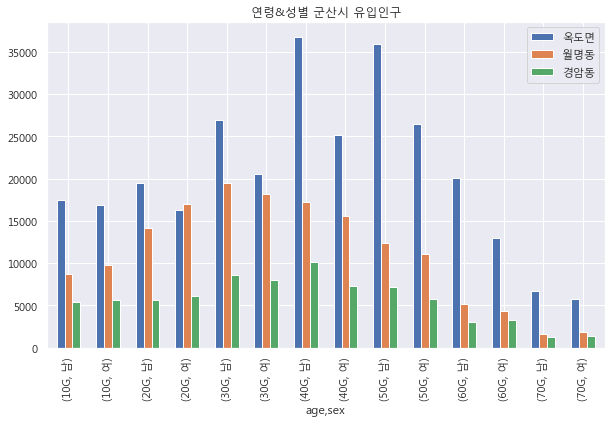

In [41]:
data[data.day.isin(['토','일'])].pivot_table(index='dst_dong', columns=['age','sex'], values='pops',aggfunc='sum').rename_axis(index=None).loc[tour_dong].T.plot(kind='bar',figsize=(10,6),width=0.6, title='연령&성별 군산시 유입인구')